<a href="https://colab.research.google.com/github/joaquinhojman/AprendizajeEstadistico-TPFinal/blob/main/Arboles_de_Decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split

In [41]:
#Cargo el set de datos
url = 'https://raw.githubusercontent.com/joaquinhojman/AprendizajeEstadistico-TPFinal/main/heart.csv'

heart_csv = pd.read_csv(url)
heart_csv

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [42]:
#Se convierten variables a categorico y encode (Leo)
'''
heart_csv['target'] = heart_csv['target'].astype('category')
heart_csv['sex'] = heart_csv['sex'].astype('category')
heart_csv['cp'] = heart_csv['cp'].astype('category')
heart_csv['fbs'] = heart_csv['fbs'].astype('category')
heart_csv['restecg'] = heart_csv['restecg'].astype('category')
heart_csv['fbs'] = heart_csv['fbs'].astype('category')
heart_csv['exang'] = heart_csv['exang'].astype('category')
heart_csv['slope'] = heart_csv['slope'].astype('category')
heart_csv['ca'] = heart_csv['ca'].astype('category')
heart_csv['thal'] = heart_csv['thal'].astype('category')

dummy_heart = pd.get_dummies(heart_csv, columns=['cp', 'restecg', 'slope', 'ca', 'thal', 'sex', 'fbs', 'exang'], drop_first=True)
'''
# split 70 / 30
X_train, X_test, y_train, y_test = train_test_split(heart_csv.drop('target', axis=1), heart_csv['target'], test_size = 0.3, random_state=23)

#Ahora ya se puede entrenar un modelo predictivo


##XGBoost como Regresor y haciendo "a mano" la clasificacion

In [5]:
#Instancio el regresor de XGBoost con 10 arboles

#Parametros iniciales medio a dedo, despues se pueden optimizar pero creo que no es el objetivo del tp

xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
#Y entreno
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [6]:
#Predigo y calculo el error. Uso logloss ---> mientras mas cercano a 0, mejor resultado (ademas la formula queda piolita en el informe)

preds = xg_reg.predict(X_test)
logloss = log_loss(y_test, preds)
logloss

0.5178089187695429

In [7]:
#Aumento a 100 el numero de arboles para predecir
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
logloss = log_loss(y_test, preds)
logloss

0.3389569455757737

In [8]:
#Reduzco la profundidad hasta 4
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
logloss = log_loss(y_test, preds)
logloss

0.33331789591114275

K-Fold Cross Validation

In [9]:
#Convierto a DMatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

#Entreno 
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 4, 'alpha': 10, 'n_estimators': 100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    as_pandas=True, seed=123)

cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.386758,0.107629,0.537223,0.089547
1,0.273566,0.012928,0.363045,0.052060
2,0.266657,0.045640,0.316164,0.025570
3,0.212333,0.023695,0.302012,0.019641
4,0.205291,0.032748,0.297250,0.013348


In [10]:
#Error final:
print((cv_results["test-error-mean"]).tail(1))

36    0.212408
Name: test-error-mean, dtype: float64


Clasificando los resultados

In [11]:
def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

#si >0.5, es 1 (won). si <0.5, es 0 (lost)

prediccion_bin = [1 if i > .5 else 0 for i in preds]
prediccion_bin[:10]

metrics = metricas(y_test, prediccion_bin)
[print(i) for i in metrics]


[[35  9]
 [ 3 44]]
0.8681318681318682
              precision    recall  f1-score   support

           0       0.92      0.80      0.85        44
           1       0.83      0.94      0.88        47

    accuracy                           0.87        91
   macro avg       0.88      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



[None, None, None]

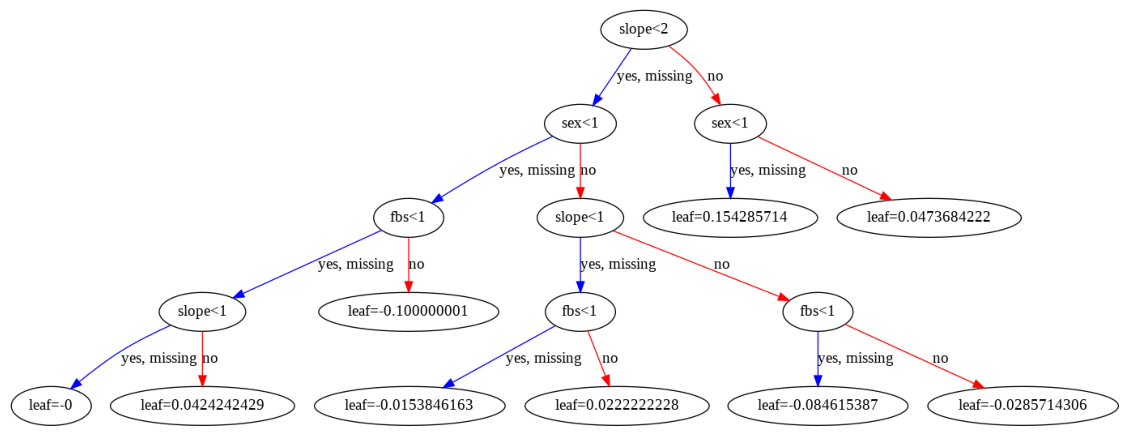

In [12]:
#Armo una visualizacion para el arbol
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_reg,num_trees=0)

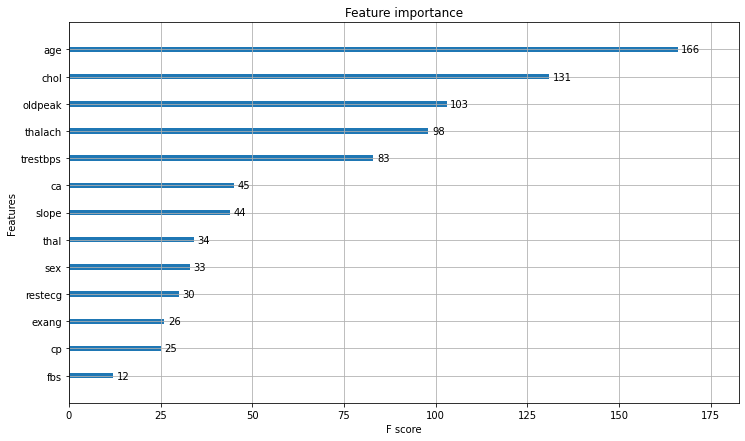

In [13]:
#Importancia de los features 
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)


##XGBoost como Clasificador

In [14]:
#Instancio el regresor de XGBoost con 10 arboles

xg_cls = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
#Y entreno
xg_cls.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [15]:
#Ahora no tiene sentido usar logloss como metrica. Uso Error Cuadratico Medio.
from sklearn.metrics import mean_squared_error

preds_cls = xg_cls.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_cls))
print("RMSE: %f" % (rmse))


RMSE: 0.363137


In [16]:
#Aumento el numero de arboles

xg_cls = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
#Y entreno
xg_cls.fit(X_train,y_train)

preds_cls = xg_cls.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_cls))
print("RMSE: %f" % (rmse))

RMSE: 0.363137


In [17]:
preds_cls

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0])

In [18]:
#Evaluacion del modelo:
def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metrics = metricas(y_test, preds_cls)
[print(i) for i in metrics]


[[35  9]
 [ 3 44]]
0.8681318681318682
              precision    recall  f1-score   support

           0       0.92      0.80      0.85        44
           1       0.83      0.94      0.88        47

    accuracy                           0.87        91
   macro avg       0.88      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



[None, None, None]

In [19]:
#Rapidamente se puede observar que la precision es igual de esta manera que usando el regresor y clasificando a mano.
#Tambien el accuracy, f1-score y el recall son iguales de esta manera.

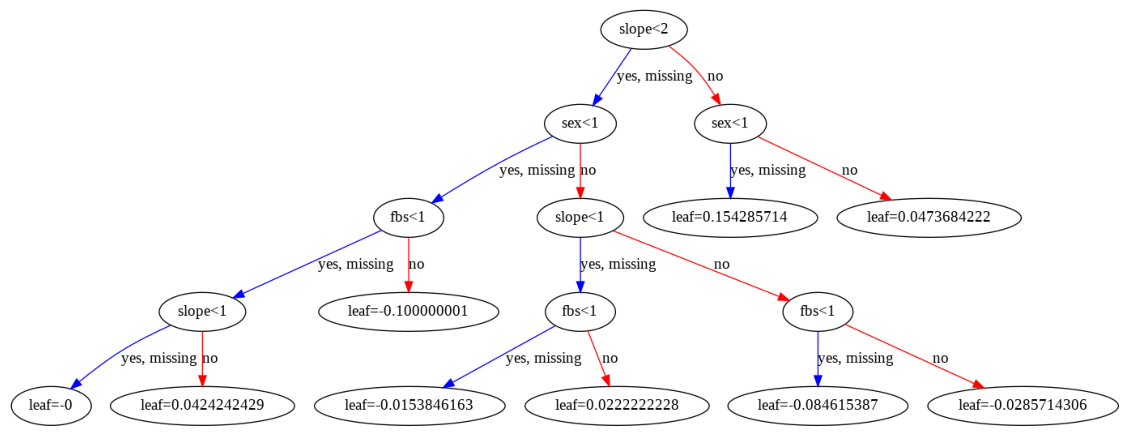

In [20]:
#Armo una visualizacion para el arbol
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_cls,num_trees=0)

#Observamos exactamente el mismo grafico que en el otro modelo (¿Por que?)

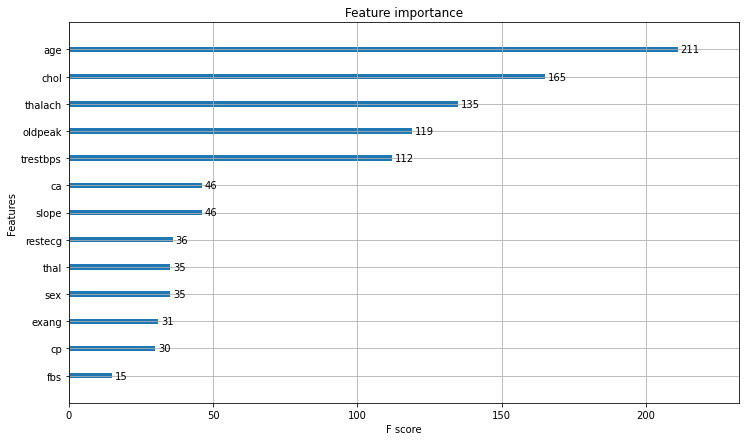

In [21]:
#Importancia de los features 
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_cls)

#Aca la importancia de cada feature es muy similar al otro modelo pero no igual

Hacemos una optimizacion a ver que pasa

In [37]:
!pip install hyperopt
from hyperopt.pyll.base import scope 
import warnings
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
# Search space definition
# space = hp.uniform('x', -2, 2)
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 0.01,8),
       # 'reg_alpha' : hp.quniform('reg_alpha', 40,50,1),
       # 'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.1,1,0.01),
        'n_estimators': hp.quniform('n_estimators', 30,200,1),
        'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),

    }

# Clasificacion: 
def hyperparameter_tuning(space):
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    model_opt=xgb.XGBClassifier(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma']#, reg_lambda=space['reg_lambda'],
                        # reg_alpha = int(space['reg_alpha']),
                        ,learning_rate=space['learning_rate'],
                         colsample_bytree=space['colsample_bytree'],
      booster='gbtree',objective ='binary:logistic',base_score=0.00001)
    
    model_opt.fit(X_train, y_train)
    pred = model_opt.predict(X_test)

    rmse = mean_squared_error(y_test, pred)
    print("ERROR: "+str(rmse))
    print(model_opt)
    #change the metric if you like
    return {'loss':rmse, 'status': STATUS_OK, 'model': model_opt}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print (best)

In [ ]:
#loss de 0.07692307692307693
'''XGBClassifier(base_score=1e-05, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.11,
              gamma=1.0973358086124976, learning_rate=0.16, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=None, n_estimators=106,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)'''

In [73]:
xg_cls_opt = xgb.XGBClassifier(base_score=1e-05, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.11,
              gamma=1.0973358086124976, learning_rate=0.16, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=None, n_estimators=106,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)
#Y entreno
xg_cls_opt.fit(X_train,y_train)

preds = xg_cls_opt.predict(X_test)
error = mean_squared_error(y_test,preds)
error

0.07692307692307693

In [74]:
#Evaluacion del modelo:
def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metrics = metricas(y_test, preds)
[print(i) for i in metrics]

[[38  6]
 [ 1 46]]
0.9230769230769231
              precision    recall  f1-score   support

           0       0.97      0.86      0.92        44
           1       0.88      0.98      0.93        47

    accuracy                           0.92        91
   macro avg       0.93      0.92      0.92        91
weighted avg       0.93      0.92      0.92        91



[None, None, None]

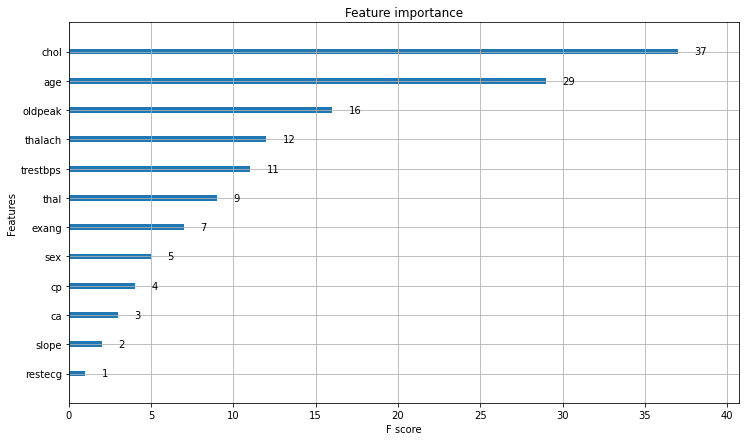

In [79]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_cls_opt)



##Visualizaciones K-MEANS (cluster analysis)